# Calculate Bidirectional Phase Correction from Scanner Metadata
Extract correction parameters from ScanImage hScan2D timing, fill fractions

In [1]:
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import tifffile
%matplotlib inline

In [5]:
# Load data and metadata
inpath = Path(r'D:\W2_DATA\yao')
tif_files = sorted(inpath.glob('*.tif'))
original_tif = [f for f in tif_files if 'corrected' not in f.name.lower()][0]
data = tifffile.imread(original_tif)
frame = np.mean(data.mean(axis=0), axis=0)

tiff_file = tifffile.TiffFile(original_tif)
meta = tiff_file.scanimage_metadata
si = meta.get('FrameData', {})

print(f'{original_tif.name}: {frame.shape}')

20251113-BrainSlice-5.3mW_cavityB_Bead3_Region6_depth-5-35um-Zoom2-Stack_00001.tif: (512, 512)


In [8]:
# Extract scanner parameters
bidirectional = si['SI.hScan2D.bidirectional']
fill_spatial = si['SI.hScan2D.fillFractionSpatial']
fill_temporal = si['SI.hScan2D.fillFractionTemporal']
line_period = si['SI.hRoiManager.linePeriod']
line_phase = si['SI.hScan2D.linePhase']
pixel_time = si['SI.hScan2D.scanPixelTimeMean']
sample_rate = si['SI.hScan2D.sampleRate']

print('Scanner Parameters:')
print(f'  Bidirectional: {bidirectional}')
print(f'  fillFractionSpatial: {fill_spatial}')
print(f'  fillFractionTemporal: {fill_temporal}')
print(f'  linePeriod: {line_period*1000:.3f} ms')
print(f'  linePhase: {line_phase}')
print(f'  scanPixelTimeMean: {pixel_time*1e6:.2f} us')
print(f'  sampleRate: {sample_rate/1e6:.2f} MHz')
print(f'  Image size: {frame.shape}')

Scanner Parameters:
  Bidirectional: True
  fillFractionSpatial: 0.8
  fillFractionTemporal: 0.8
  linePeriod: 2.304 ms
  linePhase: 0.0001638
  scanPixelTimeMean: 3.60 us
  sampleRate: 0.56 MHz
  Image size: (512, 512)


In [7]:
# Calculate phase shift from scanner timing
# linePhase gives the phase offset in seconds
# Convert to pixels based on line period and pixel time

nr, nc = frame.shape

# Line phase is the time delay between forward and reverse scans
# This translates to a pixel shift
phase_shift_px = line_phase / pixel_time

print(f'\nPhase shift from linePhase: {phase_shift_px:.3f} pixels')
print(f'  This is the uniform shift at image center')

# Fill fractions affect edge behavior
# Spatial fill fraction = active scan time / total line time
# Lower fill = longer dead time at edges = larger phase errors at edges

active_fraction = fill_spatial * fill_temporal
dead_fraction = 1 - active_fraction

print(f'\nFill fractions:')
print(f'  Active imaging: {active_fraction:.1%}')
print(f'  Dead time (edges): {dead_fraction:.1%}')

# Galvo turnaround at edges causes additional phase shift
# Model as parabolic: shift increases quadratically toward edges
# Max shift at edges depends on galvo inertia and fill fraction

# Estimate edge shift from fill fraction
# Lower fill = more turnaround time = larger edge shift
edge_multiplier = 1 / fill_spatial  # Empirical scaling
max_edge_shift = phase_shift_px * edge_multiplier

print(f'\nEstimated edge shift: {max_edge_shift:.2f} pixels')
print(f'  (Scaled by 1/fillFractionSpatial = {edge_multiplier:.2f})')


Phase shift from linePhase: 45.500 pixels
  This is the uniform shift at image center

Fill fractions:
  Active imaging: 64.0%
  Dead time (edges): 36.0%

Estimated edge shift: 56.88 pixels
  (Scaled by 1/fillFractionSpatial = 1.25)


In [9]:
# Build shift pattern
# Try multiple models using metadata parameters

x_norm = np.arange(nc) / nc  # Normalized column position [0, 1]
x_centered = x_norm - 0.5  # Centered [-0.5, 0.5]

models = {}

# Model 1: Uniform shift (linePhase only)
models['uniform'] = np.full(nc, phase_shift_px)

# Model 2: Parabolic (V-shape) based on fill fraction
# Center at linePhase, edges at max_edge_shift
parabolic = phase_shift_px + (max_edge_shift - phase_shift_px) * (4 * x_centered**2)
models['parabolic'] = parabolic

# Model 3: Sine wave (Yao's approach) tuned to metadata
# Use linePhase and fill fraction to set amplitude
A_meta = max_edge_shift / 2  # Amplitude from metadata
left_corr = -0.4
right_corr = 1.4
xn = np.linspace(left_corr * np.pi, right_corr * np.pi, nc)
sine_meta = A_meta * np.sin(xn) + phase_shift_px
models['sine_metadata'] = sine_meta

# Model 4: Asymmetric parabolic (different edge shifts)
# Left edge may have different inertia than right
left_scale = 1.2  # Empirical
right_scale = 0.8
asymmetric = phase_shift_px + np.where(
    x_centered < 0,
    left_scale * (max_edge_shift - phase_shift_px) * (4 * x_centered**2),
    right_scale * (max_edge_shift - phase_shift_px) * (4 * x_centered**2)
)
models['asymmetric'] = asymmetric

# Model 5: Scaled linePhase (simple multiplier)
scale_factors = [5, 10, 15, 20]
for sf in scale_factors:
    models[f'linePhase_x{sf}'] = np.full(nc, phase_shift_px * sf)

print(f'Created {len(models)} models from metadata')
for name, pattern in models.items():
    print(f'  {name}: [{pattern.min():.2f}, {pattern.max():.2f}] px')

Created 8 models from metadata
  uniform: [45.50, 45.50] px
  parabolic: [45.50, 56.88] px
  sine_metadata: [18.45, 73.94] px
  asymmetric: [45.50, 59.15] px
  linePhase_x5: [227.50, 227.50] px
  linePhase_x10: [455.00, 455.00] px
  linePhase_x15: [682.50, 682.50] px
  linePhase_x20: [910.00, 910.00] px


In [10]:
# Apply bidirectional correction
def apply_bidir_correction(I, dx_col):
    nr, nc = I.shape
    currentSlice = I.copy()
    currentSlice[1::2, :] = np.fliplr(currentSlice[1::2, :])
    even = currentSlice[1::2, :]
    m, even_corr = even.shape[0], np.zeros_like(even)
    x, x_src = np.arange(nc), np.arange(nc) - dx_col

    for r in range(m):
        F = interp1d(x, even[r, :], kind='linear', bounds_error=False, fill_value='extrapolate')
        even_corr[r, :] = F(x_src)

    Icorr = currentSlice.copy()
    Icorr[1::2, :] = even_corr
    currentSlice[1::2, :] = np.fliplr(currentSlice[1::2, :])
    Icorr[1::2, :] = np.fliplr(Icorr[1::2, :])
    return Icorr

# Apply all models
corrected = {}
for name, pattern in models.items():
    corrected[name] = apply_bidir_correction(frame, pattern)

print('Applied all corrections')

Applied all corrections


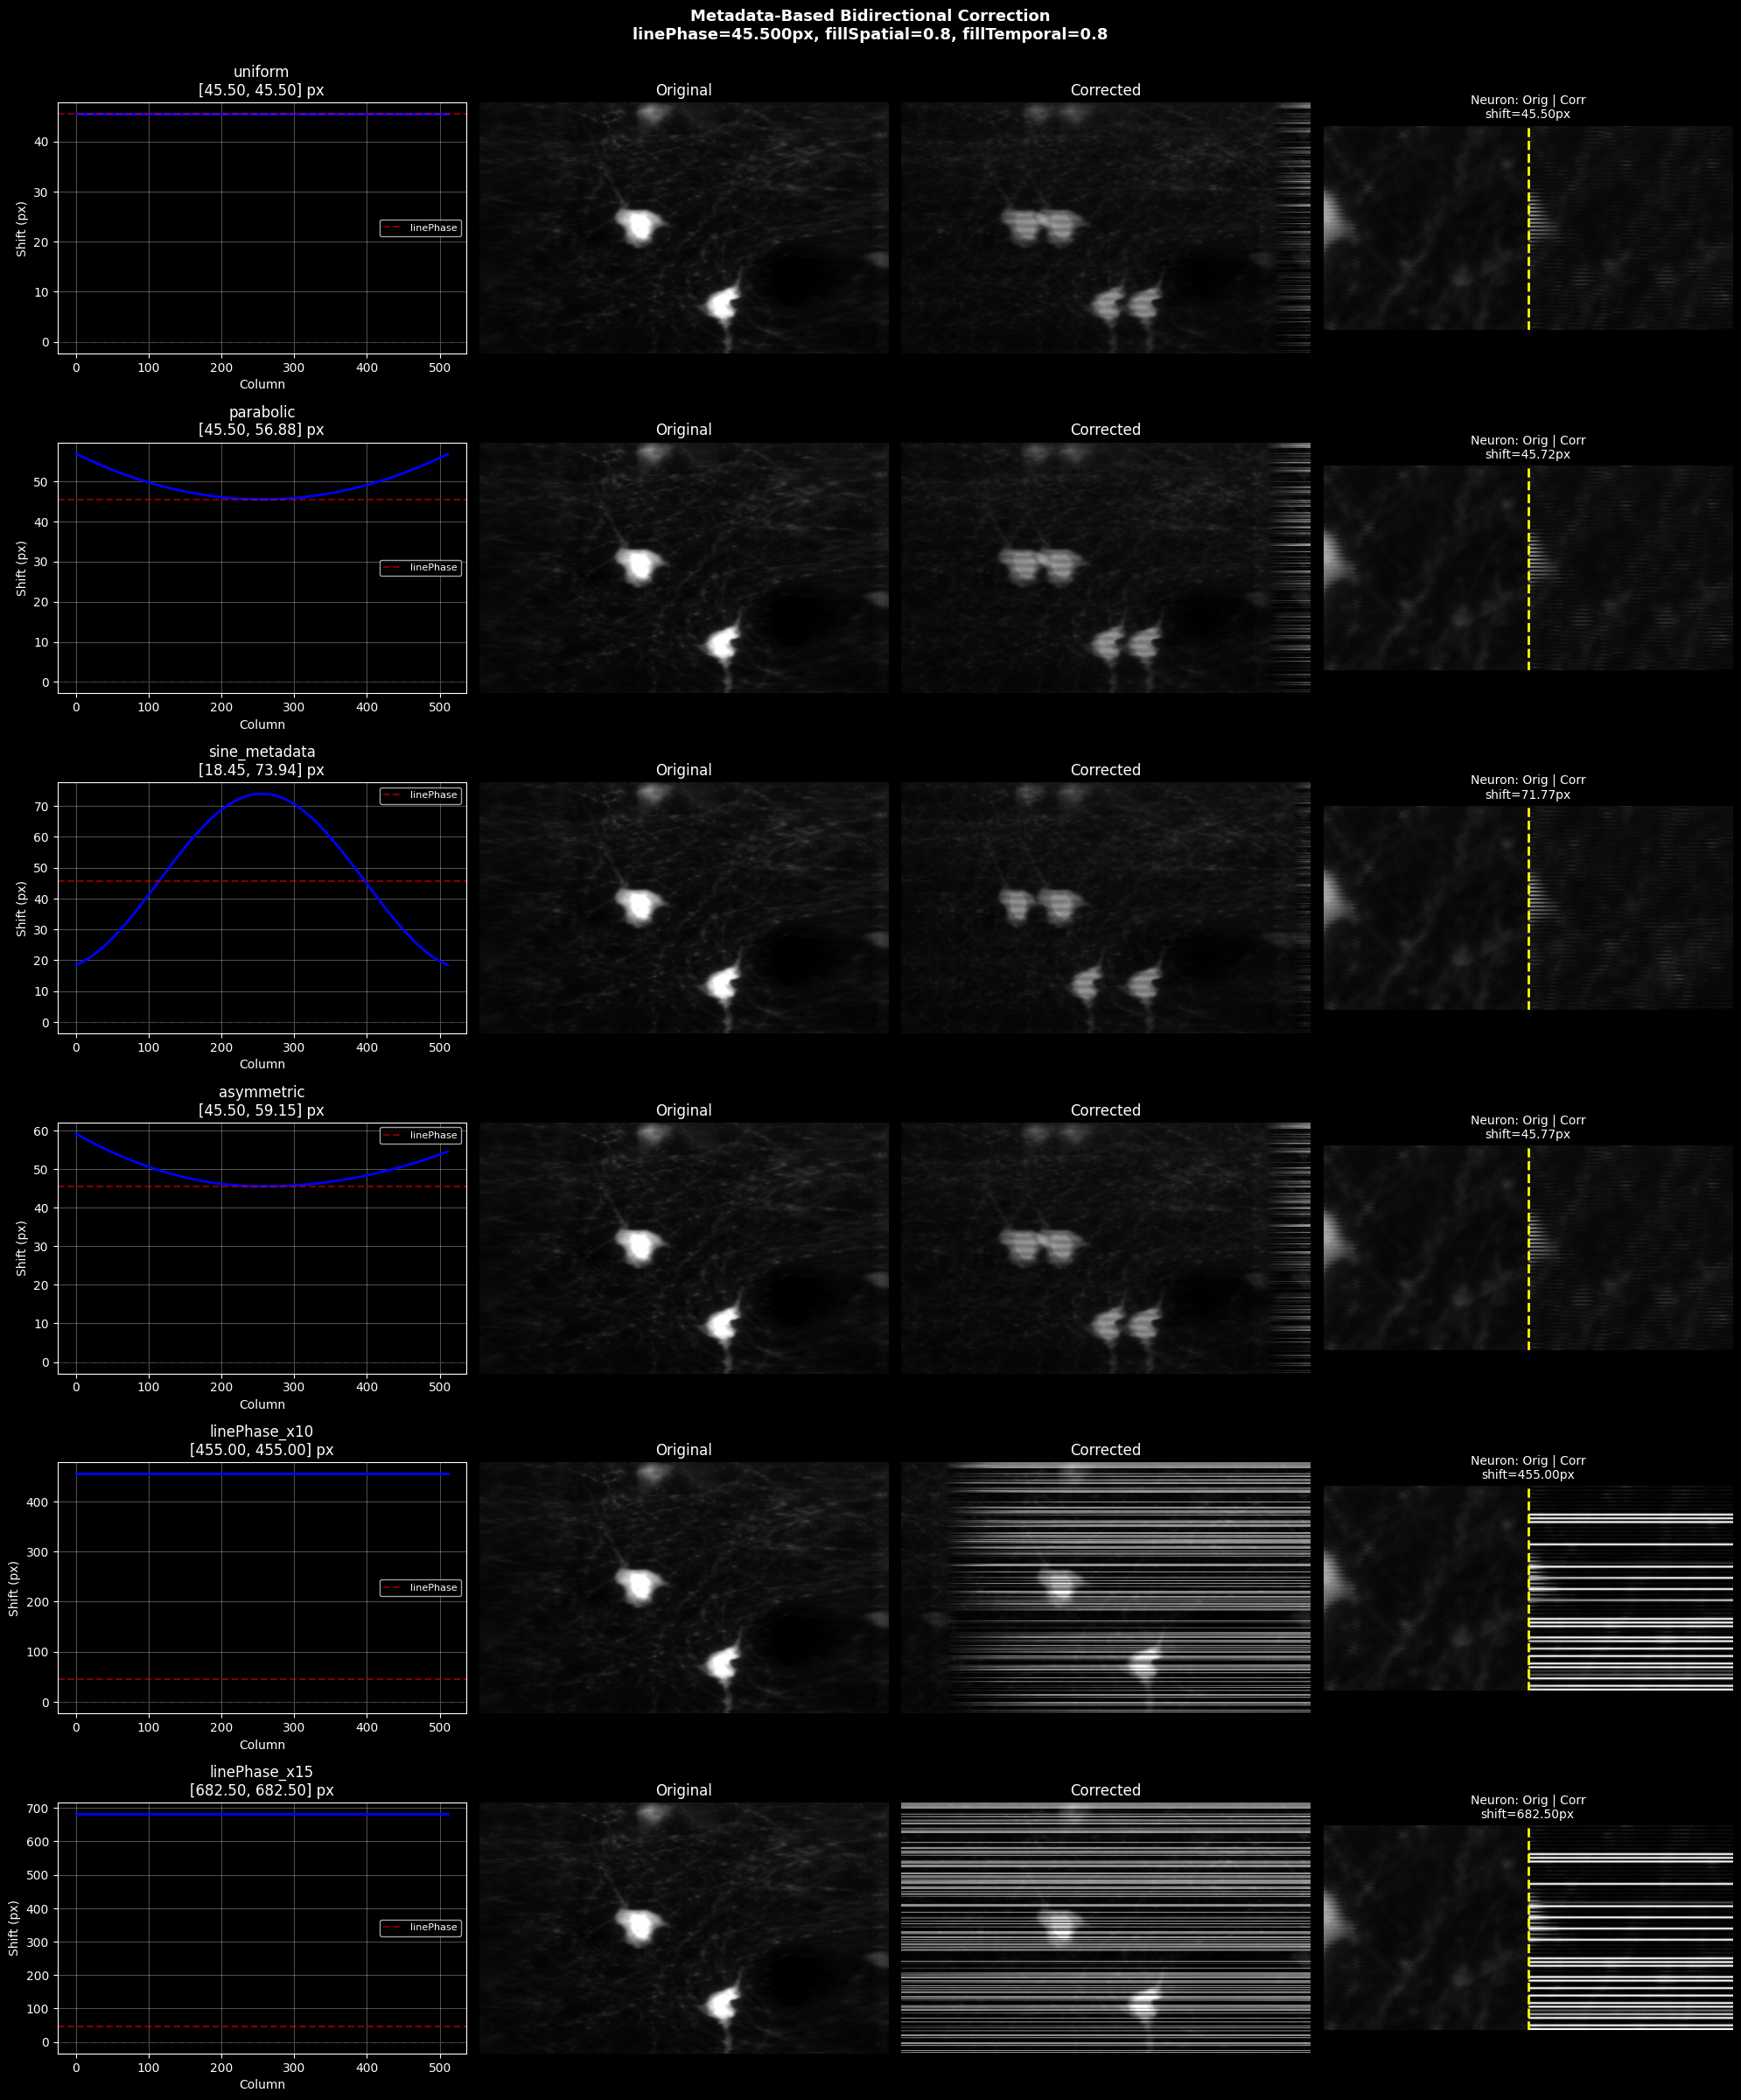

In [11]:
# Visualize - show top models
top_models = ['uniform', 'parabolic', 'sine_metadata', 'asymmetric', 'linePhase_x10', 'linePhase_x15']
n = len(top_models)

fig, axes = plt.subplots(n, 4, figsize=(20, 4*n))
vmin, vmax = np.percentile(frame, [1, 99.5])

for i, model_name in enumerate(top_models):
    pattern = models[model_name]
    corr = corrected[model_name]

    # Shift pattern
    axes[i, 0].plot(pattern, linewidth=2, color='blue')
    axes[i, 0].axhline(phase_shift_px, color='red', linestyle='--', alpha=0.5, label='linePhase')
    axes[i, 0].axhline(0, color='k', linestyle='--', alpha=0.3)
    axes[i, 0].set_ylabel('Shift (px)')
    axes[i, 0].set_xlabel('Column')
    axes[i, 0].set_title(f'{model_name}\n[{pattern.min():.2f}, {pattern.max():.2f}] px')
    axes[i, 0].grid(True, alpha=0.3)
    axes[i, 0].legend(fontsize=8)

    # Original
    axes[i, 1].imshow(frame, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto')
    axes[i, 1].set_title('Original')
    axes[i, 1].axis('off')

    # Corrected
    axes[i, 2].imshow(corr, cmap='gray', vmin=vmin, vmax=vmax, aspect='auto')
    axes[i, 2].set_title('Corrected')
    axes[i, 2].axis('off')

    # Neuron zoom (x~220)
    x_neuron = 220
    y = 192
    size = 110
    zoom_orig = frame[y:y+size, x_neuron:x_neuron+size]
    zoom_corr = corr[y:y+size, x_neuron:x_neuron+size]
    combined = np.hstack([zoom_orig, zoom_corr])
    axes[i, 3].imshow(combined, cmap='gray', vmin=vmin, vmax=vmax)
    axes[i, 3].axvline(size, color='yellow', linestyle='--', linewidth=2)
    axes[i, 3].set_title(f'Neuron: Orig | Corr\nshift={pattern[x_neuron]:.2f}px', fontsize=10)
    axes[i, 3].axis('off')

plt.suptitle('Metadata-Based Bidirectional Correction\n'
            f'linePhase={phase_shift_px:.3f}px, fillSpatial={fill_spatial}, fillTemporal={fill_temporal}',
            fontsize=13, weight='bold', y=0.998)
plt.tight_layout()

In [ ]:
# Save best model (update this after visual inspection)
best_model = 'parabolic'  # Change based on results
best_pattern = models[best_model]
best_corrected = corrected[best_model]

tifffile.imwrite(inpath / f'corrected_metadata_{best_model}.tif', best_corrected.astype(np.int16))
np.save(inpath / f'shift_pattern_metadata_{best_model}.npy', best_pattern)

print(f'Saved {best_model} model')
print(f'  Shift range: [{best_pattern.min():.2f}, {best_pattern.max():.2f}] px')